In [1]:
!pip install opencv-python
!pip install numpy
!pip install pandas
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 529 kB 5.1 MB/s 


In [48]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
import random

import torch
import torch.nn as nn
import pandas as pd
#import hashlib
from torch import flatten
from torch.utils.data import Dataset,DataLoader
from torch.optim import Adam
from sklearn.model_selection import train_test_split
from torch.nn import ReLU,MaxPool2d,Linear,Conv2d,Module, Sequential, BatchNorm2d
import torch.nn.functional as F
from torchmetrics import ConfusionMatrix

In [49]:
def f_createRandomImage():
    x,y = 100,100
    max_r = 20
    rangex, rangey = (max_r,x-max_r), (max_r,y-max_r)
    colors = [((255, 255, 0),0),((102, 204, 0),1),((0, 51, 204),2),((204, 0, 204),3),((204, 0, 0),4)]
    lst_res = []
    for color in colors:
        for i in range(500):
            
            frame = np.full((x,y,3),0,dtype="uint8")

            locx = random.randint(*rangex)
            locy = random.randint(*rangey)
            r = random.randint(10,max_r)
            
            
            cv2.circle(frame,(locx,locy),r,color[0],-1)

            frame = frame / 255.0
            #cv2.rectangle(frame,(locx-r,locy-r),(locx+r,locy+r),(0,255,0),1)
            lst_res.append([frame.reshape(3,x,y),locx-r,locy-r,locx+r,locy+r, color[1]])
            #cv2.waitKey(0)

    return lst_res

In [50]:
class cls_data(Dataset):
    def __init__(self,df) -> None:
        super().__init__()

        self.dataset = df

        print("Head of dataset: ", self.dataset.head(2))
        

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        
        return torch.tensor(self.dataset.loc[index, "image"]), torch.tensor(self.dataset.loc[index, "c"]).long()

In [51]:
class cls_model(nn.Module):

    def __init__(self):
        # call the parent constructor
        super(cls_model, self).__init__()
        self.conv1 = Conv2d(in_channels=3, out_channels=6, kernel_size=(5,5), bias=False)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 10, kernel_size=(5,5), bias=False)
        
        self.fc1 = nn.Linear(22*22*10, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 5)

    def forward(self, x):
        x = x.float()

        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        

        #x = self.conv1(x)
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [52]:
lst_data = f_createRandomImage()
df1 = pd.DataFrame({"image":[i[0] for i in lst_data], "c":[i[5] for i in lst_data]})

df_train , df_test = train_test_split(df1,test_size=.1,stratify=df1.c)

ds_train = cls_data(df_train.reset_index().drop(columns=["index"]))

ds_test = cls_data(df_test.reset_index().drop(columns=["index"]))

trainLoader = DataLoader(ds_train,batch_size=8)
testLoader = DataLoader(ds_test,batch_size=8)

Head of dataset:                                                 image  c
0  [[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...  4
1  [[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...  2
Head of dataset:                                                 image  c
0  [[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...  2
1  [[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...  3


In [53]:
df_train.c.value_counts()

4    450
2    450
1    450
3    450
0    450
Name: c, dtype: int64

In [54]:
def f_train(net, trainLoader, valLoader, optim1, device):

    #criterion1 = nn.MSELoss()#nn.BCELoss()
    criterion2 = nn.CrossEntropyLoss()

    
    
    for ep in range(10):
        for i in testLoader:
            
            net.eval()
            
            predict= net(i[0].float())
            
            predict = predict.softmax(dim=1)
            
            
            #for im1, pred,y in zip(i[0],predict,i[1]):
                
                #im1 = im1*255
                #im1 = im1.reshape((100,100,3)).int().numpy()

                
                #print(pred)
                #print(y)
                #cv2_imshow(im1)
                #cv2.waitKey(0)
            
            
        confmat = ConfusionMatrix(num_classes=5)
        for it , (batch, y) in enumerate(trainLoader):
            optim1.zero_grad()
            
            batch,y = batch.to(device), y.to(device)
            
            logits = net(batch)

            #print(logits[:,:4].shape)
            
            
            confmat.update(logits.softmax(dim=1), y)
            
            loss2 = criterion2(logits.softmax(dim=1), y)
             
            
            loss2.backward()

            optim1.step()

            
        
        print("loss2",loss2)
        print(confmat.confmat)
        

In [55]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


net = cls_model()
net.to(device)


opti = Adam(net.parameters(),lr=5e-4)

f_train(net,trainLoader,testLoader,opti,device)

loss2 tensor(0.9482, grad_fn=<NllLossBackward0>)
tensor([[404,   7,   0,  39,   0],
        [237, 159,   6,  44,   4],
        [132,   6, 154,  64,  94],
        [217,   2,   0, 231,   0],
        [110,   1,  14,  81, 244]])
loss2 tensor(0.9081, grad_fn=<NllLossBackward0>)
tensor([[449,   0,   0,   1,   0],
        [  0, 450,   0,   0,   0],
        [  0,   0, 450,   0,   0],
        [  0,   0,   0, 450,   0],
        [  0,   0,   0,   0, 450]])
loss2 tensor(0.9056, grad_fn=<NllLossBackward0>)
tensor([[450,   0,   0,   0,   0],
        [  0, 450,   0,   0,   0],
        [  0,   0, 450,   0,   0],
        [  0,   0,   0, 450,   0],
        [  0,   0,   0,   0, 450]])


KeyboardInterrupt: ignored

In [30]:
confmat = ConfusionMatrix(num_classes=5)
for i in testLoader:
            
    net.eval()

    predict= net(i[0].float())

    predict = predict.softmax(dim=1)

    confmat.update(predict.argmax(dim=1), i[1])
    for im1, pred,y in zip(i[0],predict,i[1]):
        
        im1 = im1*255
        im1 = im1.reshape((100,100,3)).int().numpy()

        
        print(pred)
        print(y)
        #cv2_imshow(im1)
        #cv2.waitKey(0)
confmat.confmat
    



tensor([0.0000e+00, 5.8930e-15, 4.4842e-07, 1.1915e-27, 1.0000e+00],
       grad_fn=<UnbindBackward0>)
tensor(4)
tensor([1.0412e-17, 1.6555e-05, 8.5162e-03, 1.2817e-09, 9.9147e-01],
       grad_fn=<UnbindBackward0>)
tensor(4)
tensor([6.3634e-06, 4.3433e-05, 1.4730e-13, 9.9995e-01, 6.7432e-19],
       grad_fn=<UnbindBackward0>)
tensor(3)
tensor([1.4013e-45, 1.3264e-05, 9.9998e-01, 2.5378e-20, 3.4098e-06],
       grad_fn=<UnbindBackward0>)
tensor(2)
tensor([2.5307e-35, 2.1958e-05, 9.7019e-01, 4.2028e-16, 2.9787e-02],
       grad_fn=<UnbindBackward0>)
tensor(2)
tensor([9.9999e-01, 9.6786e-13, 1.6920e-21, 7.6276e-06, 5.3975e-26],
       grad_fn=<UnbindBackward0>)
tensor(0)
tensor([1.1359e-25, 1.7532e-07, 1.3607e-03, 1.0739e-13, 9.9864e-01],
       grad_fn=<UnbindBackward0>)
tensor(4)
tensor([7.2449e-22, 9.9647e-01, 3.5297e-03, 1.0787e-07, 5.1446e-08],
       grad_fn=<UnbindBackward0>)
tensor(1)
tensor([4.7058e-03, 4.0798e-02, 6.0008e-05, 9.5443e-01, 1.0818e-06],
       grad_fn=<UnbindBackw

tensor([[46,  0,  0,  0,  0],
        [ 0, 42,  7,  0,  0],
        [ 0,  0, 34,  0, 14],
        [ 0,  1,  0, 50,  0],
        [ 0,  0,  0,  0, 56]])

In [28]:
predict.argmax(dim=1)
target = torch.tensor([2, 1, 0, 0])
preds = torch.tensor([2, 1, 0, 1])
confmat = ConfusionMatrix(num_classes=3)
confmat.update(preds, target)
confmat.update(preds,target)
confmat.confmat

tensor([[2, 2, 0],
        [0, 2, 0],
        [0, 0, 2]])

tensor([[4, 4, 0],
        [0, 4, 0],
        [0, 0, 4]])

In [ ]:
# Example of target with class indices
loss = nn.CrossEntropyLoss()
input = torch.randn(3, 5, requires_grad=True)
target = torch.empty(3, dtype=torch.long).random_(5)
output = loss(input, target)
output.backward()
# Example of target with class probabilities
#input = torch.randn(3, 5, requires_grad=True)
#target = torch.randn(3, 5).softmax(dim=1)
#output = loss(input, target)
#output.backward()

In [ ]:
input

tensor([[ 0.0817,  0.0563,  0.1528, -0.9440, -1.3005],
        [-0.9126,  0.7927,  0.8036, -0.7458,  0.6431],
        [ 1.3233, -0.4808,  0.1580,  0.3691,  1.8375]], requires_grad=True)

In [ ]:
for i in testLoader:
    #print(i[0])
    #print(i[0])
    print(i[0].shape)
    break
    predict= net(i[0].float())
    predict = predict.int().numpy()

    for im1,pred in zip(i[0],predict):
        im1 = im1*255
        im1 = im1.reshape((100,100,3)).int().numpy()
        
        cv2.rectangle(im1,(pred[0],pred[1]), (pred[2],pred[3]), (100,100,10))
        cv2_imshow(im1)
        cv2.waitKey(0)
    print(i[0][0].shape)
    break
    

torch.Size([8, 3, 100, 100])


In [ ]:
484**.5


22.0

In [ ]:
conv1 = Conv2d(in_channels=3,out_channels=3,kernel_size=(3,3),bias=False)
conv1.weight

Parameter containing:
tensor([[[[ 0.0011,  0.1858,  0.1020],
          [-0.1136,  0.1689, -0.1445],
          [ 0.1758,  0.1650, -0.0876]],

         [[-0.0139,  0.0555,  0.0977],
          [-0.0348,  0.1207, -0.0137],
          [-0.1905,  0.1751, -0.1773]],

         [[-0.1543,  0.0712, -0.1279],
          [-0.0335, -0.1515, -0.1466],
          [-0.1791,  0.0623,  0.1715]]],


        [[[-0.1903, -0.1917, -0.0287],
          [-0.0720, -0.1709,  0.0624],
          [ 0.1402,  0.0623, -0.1692]],

         [[ 0.0137,  0.0968,  0.1519],
          [-0.0460, -0.1821,  0.0710],
          [-0.0833, -0.0469,  0.0258]],

         [[-0.0260,  0.0587,  0.0104],
          [ 0.0936,  0.0519, -0.0468],
          [ 0.0876, -0.0981,  0.0747]]],


        [[[ 0.0938, -0.1895, -0.1038],
          [ 0.1030,  0.0601,  0.1689],
          [ 0.1187, -0.0931, -0.0906]],

         [[ 0.1142,  0.0122, -0.1104],
          [-0.0028, -0.1261, -0.1335],
          [ 0.1713,  0.0679, -0.0735]],

         [[ 0.0638,  0

In [ ]:
b=conv1(a)
b

tensor([[[[-0.0161, -0.0161, -0.0161],
          [-0.0161, -0.0161, -0.0161],
          [-0.0161, -0.0161, -0.0161]],

         [[-0.3510, -0.3510, -0.3510],
          [-0.3510, -0.3510, -0.3510],
          [-0.3510, -0.3510, -0.3510]],

         [[-0.2258, -0.2258, -0.2258],
          [-0.2258, -0.2258, -0.2258],
          [-0.2258, -0.2258, -0.2258]]],


        [[[-0.0161, -0.0161, -0.0161],
          [-0.0161, -0.0161, -0.0161],
          [-0.0161, -0.0161, -0.0161]],

         [[-0.3510, -0.3510, -0.3510],
          [-0.3510, -0.3510, -0.3510],
          [-0.3510, -0.3510, -0.3510]],

         [[-0.2258, -0.2258, -0.2258],
          [-0.2258, -0.2258, -0.2258],
          [-0.2258, -0.2258, -0.2258]]],


        [[[-0.0161, -0.0161, -0.0161],
          [-0.0161, -0.0161, -0.0161],
          [-0.0161, -0.0161, -0.0161]],

         [[-0.3510, -0.3510, -0.3510],
          [-0.3510, -0.3510, -0.3510],
          [-0.3510, -0.3510, -0.3510]],

         [[-0.2258, -0.2258, -0.2258],
     

In [ ]:
F.softmax(torch.arange(1,10),dim=0)

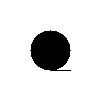

-1

In [ ]:
frame = np.full((100,100),255,dtype="uint8")
#cv2.putText(frame,"1", (50,70),cv2.FONT_HERSHEY_PLAIN,1,(0,0,0))
im1 = cv2.circle(frame,(50,50),20,(0,0,0),-1)
cv2.line(frame,(50,70),(70,70),(0,255,0))
cv2_imshow(frame)
cv2.waitKey(0)

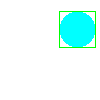

((255, 255, 0), 1)

In [ ]:
x,y = 100,100
max_r = 20
rangex, rangey = (max_r,x-max_r), (max_r,y-max_r)
frame = np.full((x,y,3),255,dtype="uint8")

locx = random.randint(*rangex)
locy = random.randint(*rangey)
r = random.randint(10,max_r)
color = random.choice([((255, 255, 0),1),((102, 204, 0),2),((0, 51, 204),3),((204, 0, 204),4),((204, 0, 0),5)])
im1 = cv2.circle(frame,(locx,locy),r,color[0],-1)
cv2.rectangle(frame,(locx-r,locy-r),(locx+r,locy+r),(0,255,0),1)
cv2_imshow(frame)
cv2.waitKey(0)
color